In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory 
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download msambare/fer2013 # downloading the datset

 96% 58.0M/60.3M [00:03<00:00, 24.2MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.5MB/s]


In [ ]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import numpy as np
import cv2
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# import os 
# os.remove("/kaggle/working/model.h5")

In [ ]:
train_dir = '/content/train'
val_dir = '/content/test'
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same', input_shape = (48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
emotion_model.add(BatchNormalization())
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation = 'relu'))
emotion_model.add(Dropout(0.25))

emotion_model.add(Dense(256, activation = 'relu'))
emotion_model.add(Dropout(0.25))

emotion_model.add(Dense(7, activation = 'softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
# gets 75% accuracy and 65% val_accuracy approx.

In [ ]:
#print(emotion_model.summary())
# plot model
print(emotion_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
# compiling model

emotion_model.compile(loss='categorical_crossentropy',
                       optimizer = Adam(lr=0.0001, decay = 1e-6),
                       metrics = ['accuracy'])

emotion_model_info = emotion_model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = 200,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size
)

emotion_model.save_weights('/kaggle/working/model.h5')

Epoch 1/200
448/448 [==============================] - ETA: 0s - loss: 7.3784 - accuracy: 0.2354

KeyboardInterrupt: ignored

In [ ]:
# compiling model

emotion_model.compile(loss='categorical_crossentropy',
                       optimizer = Adam(lr=0.0001, decay = 1e-6),
                       metrics = ['accuracy'])

emotion_model_info = emotion_model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = 200,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size
)

emotion_model.save_weights('/kaggle/working/model.h5')

Epoch 1/200
448/448 [==============================] - 27s 40ms/step - loss: 7.4544 - accuracy: 0.2302 - val_loss: 7.0892 - val_accuracy: 0.2573
Epoch 2/200
448/448 [==============================] - 20s 46ms/step - loss: 6.1141 - accuracy: 0.2846 - val_loss: 5.5668 - val_accuracy: 0.3145
Epoch 3/200
448/448 [==============================] - 17s 39ms/step - loss: 4.9063 - accuracy: 0.3443 - val_loss: 4.3979 - val_accuracy: 0.3836
Epoch 4/200
448/448 [==============================] - 17s 38ms/step - loss: 3.9481 - accuracy: 0.3865 - val_loss: 3.5613 - val_accuracy: 0.4268
Epoch 5/200
448/448 [==============================] - 17s 38ms/step - loss: 3.2445 - accuracy: 0.4234 - val_loss: 3.1806 - val_accuracy: 0.3429
Epoch 6/200
448/448 [==============================] - 18s 40ms/step - loss: 2.7368 - accuracy: 0.4587 - val_loss: 2.4762 - val_accuracy: 0.4939
Epoch 7/200
448/448 [==============================] - 17s 38ms/step - loss: 2.3712 - accuracy: 0.4917 - val_loss: 2.2498 - val_ac

In [ ]:
# plotting accuracy

plt.plot(emotion_model_info.history['accuracy'])
plt.plot(emotion_model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

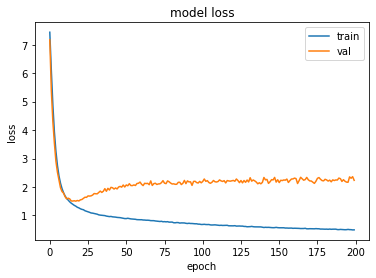

In [ ]:
# plotting model loss

plt.plot(emotion_model_info.history['loss'])
plt.plot(emotion_model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

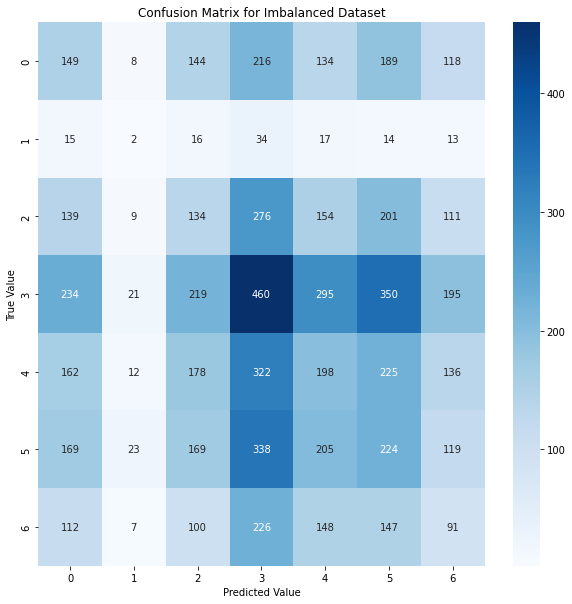

              precision    recall  f1-score   support

       Angry       0.15      0.16      0.15       958
     Disgust       0.02      0.02      0.02       111
        Fear       0.14      0.13      0.14      1024
       Happy       0.25      0.26      0.25      1774
     Neutral       0.17      0.16      0.17      1233
         Sad       0.17      0.18      0.17      1247
    Surprise       0.12      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.15      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



In [ ]:
#Confution Matrix and Classification Report
Y_pred = emotion_model.predict_generator(validation_generator, validation_generator.n // validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(validation_generator.classes, y_pred))
# print('Classification Report')

plt.figure(figsize=(10, 10))
ax = plt.axes()
df_confusion = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(df_confusion, annot=True, annot_kws={"size": 10}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix for Imbalanced Dataset')
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.show()

target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))